In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_df = pd.read_csv("/kaggle/input/ag-news-classification-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ag-news-classification-dataset/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape) 
train_df.head()

Train shape: (120000, 3)
Test shape: (7600, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
train_df['text'] = train_df['Title'] + " " + train_df['Description']
test_df['text'] = test_df['Title'] + " " + test_df['Description']


In [6]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['Class Index']
y_test = test_df['Class Index']

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9068421052631579

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.97      0.96      1900
           3       0.88      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



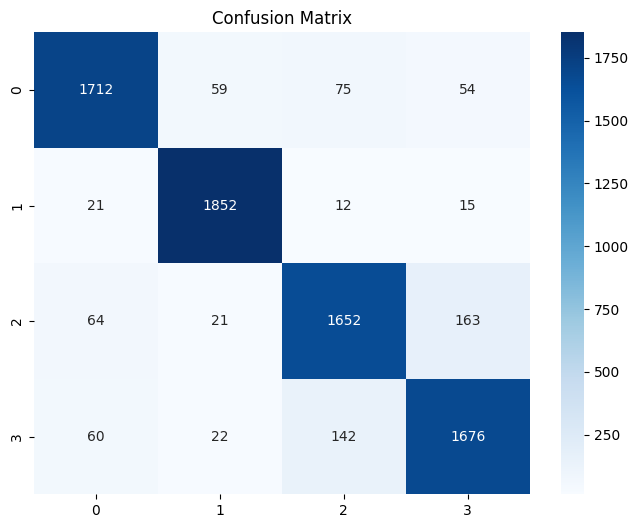

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

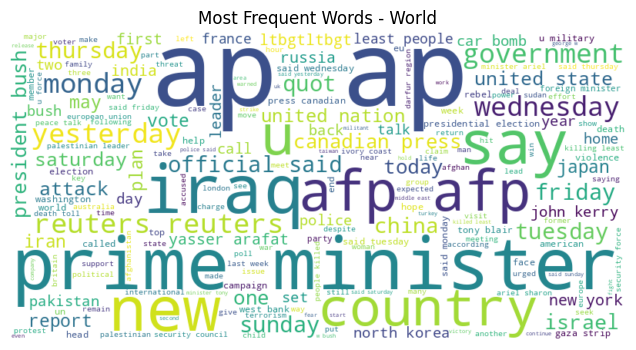

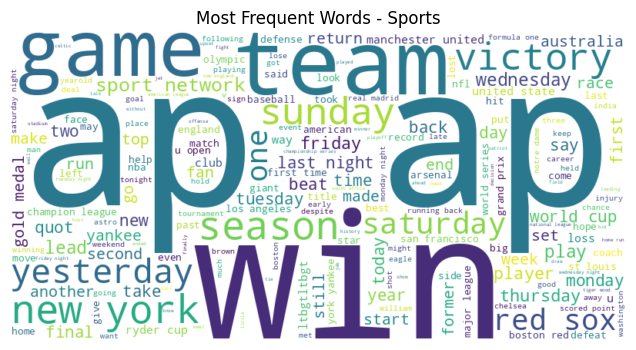

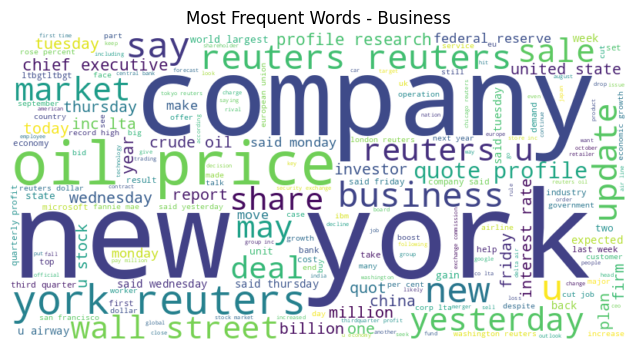

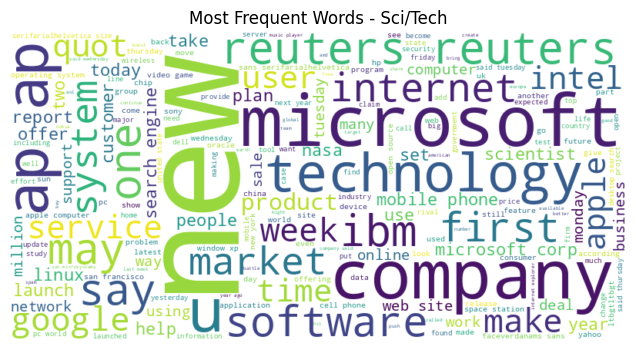

In [11]:

label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}  

for label, name in label_map.items():
    text = " ".join(train_df[train_df['Class Index'] == label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Frequent Words - {name}")
    plt.show()


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

y_train_ = y_train - 1
y_test_ = y_test - 1

y_train_cat = to_categorical(y_train_, num_classes=4)
y_test_cat = to_categorical(y_test_, num_classes=4)

model_nn = Sequential([
    Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

model_nn.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Train model
history = model_nn.fit(
    X_train_scaled, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_scaled, y_test_cat),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8202 - loss: 0.5142 - val_accuracy: 0.9007 - val_loss: 0.2961
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9218 - loss: 0.2265 - val_accuracy: 0.9041 - val_loss: 0.2937
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9394 - loss: 0.1712 - val_accuracy: 0.9050 - val_loss: 0.3115
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9537 - loss: 0.1260 - val_accuracy: 0.9037 - val_loss: 0.3462
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9621 - loss: 0.0983 - val_accuracy: 0.9022 - val_loss: 0.3852
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9723 - loss: 0.0752 - val_accuracy: 0.9049 - val_loss: 0.4245
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9773 - loss: 0.0629 - val_accuracy: 0.9026 - val_loss: 0.4692
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9814 - loss: 0.0524 - 